<a href="https://colab.research.google.com/github/artificialcoder02/StockPricePrediction_GRU/blob/main/JPM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries


In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

import itertools
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from numpy import array

#Importing Dataset

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
root_path = "/content/gdrive/MyDrive/JPM (1).csv"

In [5]:

stock_df=pd.read_csv(root_path)
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/12/2018,111.559998,114.389999,111.500000,113.370003,97.591393,16435500
1,4/13/2018,115.019997,115.150002,109.050003,110.300003,94.948662,39152800
2,4/16/2018,110.940002,111.470001,109.790001,110.209999,94.871178,16580500
3,4/17/2018,111.370003,111.919998,109.989998,110.209999,94.871178,15501400
4,4/18/2018,110.529999,111.070000,108.889999,109.320000,94.105057,16081400


In [6]:
stock_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:

stock_df = stock_df.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Adj Close': 'adj_close','Volume':'volume'})
stock_df.head()

,date,open,high,low,close,adj_close,volume
0,4/12/2018,111.559998,114.389999,111.500000,113.370003,97.591393,16435500
1,4/13/2018,115.019997,115.150002,109.050003,110.300003,94.948662,39152800
2,4/16/2018,110.940002,111.470001,109.790001,110.209999,94.871178,16580500
3,4/17/2018,111.370003,111.919998,109.989998,110.209999,94.871178,15501400
4,4/18/2018,110.529999,111.070000,108.889999,109.320000,94.105057,16081400


In [8]:

print("Checking the total number of days",stock_df.shape[0])
print("Checking the total number of fields",stock_df.shape[1])


Checking the total number of days 1258
Checking the total number of fields 7


#Data Preprocessing


In [9]:

print("NUll values",stock_df.isnull().values.sum())
print("NA values",stock_df.isna().values.any())

NUll values 0
NA values False


#Summary of the stocks

In [10]:

stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1258 non-null   object 
 1   open       1258 non-null   float64
 2   high       1258 non-null   float64
 3   low        1258 non-null   float64
 4   close      1258 non-null   float64
 5   adj_close  1258 non-null   float64
 6   volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


#Changing the Date Time format to a more computable type

In [11]:

stock_df['date']=pd.to_datetime(stock_df['date'],utc=True)

In [12]:

stock_df.info()
     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1258 non-null   datetime64[ns, UTC]
 1   open       1258 non-null   float64            
 2   high       1258 non-null   float64            
 3   low        1258 non-null   float64            
 4   close      1258 non-null   float64            
 5   adj_close  1258 non-null   float64            
 6   volume     1258 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 68.9 KB


#Checking the Time Period of the Stock

In [13]:

print("Starting date:", stock_df.iloc[0][0])
#grabbing the starting date
print("Ending date:",stock_df.iloc[-1][0])
#grabbing the ending date
print("Duration: ",stock_df.iloc[-1][0]-stock_df.iloc[0][0])

Starting date: 2018-04-12 00:00:00+00:00
Ending date: 2023-04-11 00:00:00+00:00
Duration:  1825 days 00:00:00


#Comparing the Trends

In [14]:
names = cycle(['Open Price','Close Price','High Price', 'Low Price'])

fig = px.line(stock_df, x=stock_df.date, y=[stock_df['open'],stock_df['close'],stock_df['high'],stock_df['low']],labels={'date':'Date','value':'Stock Value'})
     

In [15]:
fig.update_layout(title_text='Stock Analysis Chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()
     

#Data Preparation


#Seperating Stock Close as a seperate dataframe 

In [16]:

stock_df_close = stock_df[['date','close']]
print("The shape of the closed dataframe is",stock_df_close.shape)

The shape of the closed dataframe is (1258, 2)


#Taking the Data only from 2021 due to post pandemic market volatality

In [17]:
stock_df_closel1y = stock_df_close[stock_df_close['date']>'2021-10-03']
stock_df_close1ly_original_gt = stock_df_closel1y.copy()
print("Total data for production : ",stock_df_closel1y.shape[0])

Total data for production :  382


#Train Test Split of the data

In [18]:

training_size=int(len(stock_df_closel1y)*0.80)
test_size=len(stock_df_closel1y)-training_size
train_data, test_data = stock_df_closel1y[0:training_size], stock_df_closel1y[training_size:len(stock_df_closel1y)]
print("Training data: ", train_data.shape)
print("Test data: ", test_data.shape)


Training data:  (305, 2)
Test data:  (77, 2)


#Normalising the Close Price

In [19]:
print(train_data['date'])

876    2021-10-04 00:00:00+00:00
877    2021-10-05 00:00:00+00:00
878    2021-10-06 00:00:00+00:00
879    2021-10-07 00:00:00+00:00
880    2021-10-08 00:00:00+00:00
                  ...           
1176   2022-12-12 00:00:00+00:00
1177   2022-12-13 00:00:00+00:00
1178   2022-12-14 00:00:00+00:00
1179   2022-12-15 00:00:00+00:00
1180   2022-12-16 00:00:00+00:00
Name: date, Length: 305, dtype: datetime64[ns, UTC]


In [20]:
fig = px.scatter(train_data['date'],train_data['close'])
fig.show()

In [21]:
fig = px.box(train_data,train_data["close"])
fig.show()

In [22]:
fig = px.scatter(test_data['date'],test_data['close'])
fig.show()

In [23]:
del train_data['date']
del test_data['date']

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data = scaler.transform(np.array(test_data).reshape(-1,1))
print(train_data.shape)
print(test_data.shape)

(305, 1)
(77, 1)


In [25]:
import matplotlib.pyplot as plt


In [26]:
train_data

array([[0.93082209],
       [0.95531374],
       [0.96046985],
       [0.97579486],
       [0.97765686],
       [0.92638213],
       [0.9080493 ],
       [0.84560299],
       [0.88097969],
       [0.92595248],
       [0.92509315],
       [0.95402475],
       [0.98653677],
       [0.96734461],
       [1.        ],
       [0.98796911],
       [0.99455736],
       [0.943426  ],
       [0.97966202],
       [0.97293039],
       [0.97164142],
       [0.9812375 ],
       [0.98209682],
       [0.95001424],
       [0.94657697],
       [0.96104267],
       [0.94270983],
       [0.94041816],
       [0.94027502],
       [0.92953311],
       [0.92523631],
       [0.9080493 ],
       [0.89530223],
       [0.87496425],
       [0.84445716],
       [0.8935836 ],
       [0.9498711 ],
       [0.93096545],
       [0.85892286],
       [0.84889712],
       [0.8145231 ],
       [0.80105987],
       [0.84861083],
       [0.8067888 ],
       [0.83357211],
       [0.86808949],
       [0.84144956],
       [0.837

#Modifying the Close Price of a dataset in order to perform Time-Series Analysis


##We are considering the previous 3 timestamps and trying to predict the next timestamp

In [27]:
def create_sliding_window(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [28]:
time_step =15
X_train, y_train = create_sliding_window(train_data,time_step)
X_test, y_test = create_sliding_window(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (289, 15)
y_train:  (289,)
X_test:  (61, 15)
y_test:  (61,)


#Model Building 

For building the model and implementing Gated Recurrent Network we need to reshape the data into 3D tensor format 

In [29]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


In [30]:
#converting them into 3d vectors
print("X train: ",X_train.shape)
print("X_test: ", X_test.shape)

X train:  (289, 15, 1)
X_test:  (61, 15, 1)


Since we got 3 parameters ie, Samples,Time_steps and features that means our reshape was successful

##Using keras.backend.clearsession to prevent memory leaks which occur over time due to accumulation of unused resources.

In [31]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
10/10 [==============================] - 11s 339ms/step - loss: 0.1226 - val_loss: 0.0179
Epoch 2/200
10/10 [==============================] - 1s 76ms/step - loss: 0.0335 - val_loss: 0.0029
Epoch 3/200
10/10 [==============================] - 1s 68ms/step - loss: 0.0194 - val_loss: 0.0043
Epoch 4/200
10/10 [==============================] - 1s 59ms/step - loss: 0.0131 - val_loss: 0.0033
Epoch 5/200
10/10 [==============================] - 1s 63ms/step - loss: 0.0113 - val_loss: 0.0026
Epoch 6/200
10/10 [==============================] - 1s 70ms/step - loss: 0.0092 - val_loss: 0.0022
Epoch 7/200
10/10 [==============================] - 1s 64ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 8/200
10/10 [==============================] - 1s 64ms/step - loss: 0.0085 - val_loss: 0.0024
Epoch 9/200
10/10 [==============================] - 1s 61ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 10/200
10/10 [==============================] - 1s 64ms/step - loss: 0.0076 - val_loss: 0.00

#Plotting Losses

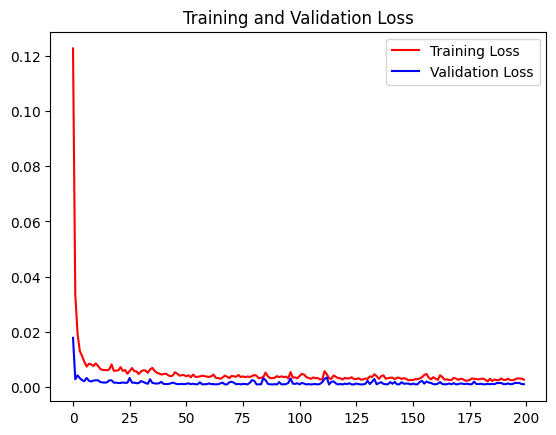

<Figure size 640x480 with 0 Axes>

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend(loc=0)
plt.figure()
plt.show()
     

#Saving the Model 

In [35]:
model.save('alpha_model.h5')

#Model Predictions

In [36]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

2/2 [==============================] - 0s 13ms/step


((289, 1), (61, 1))

#Model Evaluation

##Inverse scaling the data since we have already preprocessed and normalised the data, now we want to make predictions on the original scale of the data

In [37]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [38]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_error 

In [39]:
import math
print ("Train data RMSE: ",math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict))

Train data RMSE:  2.378700763603434
Train data MSE:  5.65821732276756
Train data MAE:  1.8658582595358457


In [40]:
print ("Test data RMSE: ",math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict))

Test data RMSE:  2.30439387394775
Test data MSE:  5.310231126287919
Test data MAE:  1.7573014623383052


#Using Explained Variance Regression Score

###explained_variance_score tells us how much variance is explained by our model. The maximum value is 1, and higher the EVS better is our model.

In [41]:
print("Train data explained variance regression score ", explained_variance_score(original_ytrain,train_predict))
print("Test data explained variance regression score ", explained_variance_score(original_ytest,test_predict))

Train data explained variance regression score  0.9841720323658778
Test data explained variance regression score  0.8503041797100271


#Using R2 Score 

In [42]:
print("Train data R2 score: ", r2_score(original_ytrain,train_predict))
print("Test data R2 score: ", r2_score(original_ytest,test_predict))

Train data R2 score:  0.9841720215657431
Test data R2 score:  0.8492738301370044


#Comparing the Original and Prediction of the Stock Prices

In [43]:
stock_df_closel1y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 876 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    382 non-null    datetime64[ns, UTC]
 1   close   382 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 9.0 KB


In [44]:
del stock_df_closel1y['date']

look_back = time_step

train_predict_look_ahead = np.empty_like(stock_df_closel1y)

train_predict_look_ahead[:,:] = np.nan

train_predict_look_ahead[look_back:len(train_predict)+look_back,:] = train_predict

print("Train predicted data: ",train_predict_look_ahead.shape)

test_predict_look_ahead = np.empty_like(stock_df_closel1y)

train_predict_look_ahead[:,:]=np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(stock_df_closel1y)-1,:] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price', 'Train predicted price','Test predicted close price'])

plotdf = pd.DataFrame({'date':stock_df_close1ly_original_gt['date'],
                       'original_close': stock_df_close1ly_original_gt['close'],
                       'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                       'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})




Train predicted data:  (382, 1)
Test predicted data:  (382, 1)


In [45]:
fix = px.line(plotdf, x=plotdf['date'], y=[plotdf['original_close'], plotdf['train_predicted_close'], plotdf['test_predicted_close']],
                                           labels={'Value':'Stock Price','date':'Date'})

fix.update_layout(title_text='Comparison between original close price vs predicted close price',
                  plot_bgcolor='white',font_size=15,font_color='black',legend_title_text='Close Price')

fix.for_each_trace(lambda t: t.update(name = next(names)))

fix.update_xaxes(showgrid=False)
fix.update_yaxes(showgrid=False)
fix.show()

#Calculating the different regression losses

##Mean Poisson Deviance measures the difference between predicted and actual values in Poisson regression models for count data. Mean Gamma Deviance measures the difference in gamma regression models for positively skewed continuous variables. Both are negative log-likelihoods and lower values indicate better fit.

In [46]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain,train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))

Train data MGD:  0.00033150877007167597
Test data MGD:  0.00029505075060468023


In [47]:
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MPD:  0.04288624154413459
Test data MPD:  0.039554291167628326


#Prediction for the next 30 days 

In [240]:
x_input=test_data[len(test_data)-time_step-1:].reshape(1,-1)
print("x_input.shape",x_input.shape)
print("x_input",x_input)

x_input.shape (1, 16)
x_input [[0.36064165 0.40948158 0.36121457 0.35634484 0.32870245 0.37997717
  0.38556296 0.38928674 0.38370096 0.4060441  0.4038958  0.37897449
  0.36737327 0.36536812 0.37138356 0.38040683]]


In [241]:
temp_input=list(x_input)
print(temp_input)

[array([0.36064165, 0.40948158, 0.36121457, 0.35634484, 0.32870245,
       0.37997717, 0.38556296, 0.38928674, 0.38370096, 0.4060441 ,
       0.4038958 , 0.37897449, 0.36737327, 0.36536812, 0.37138356,
       0.38040683])]


In [242]:
temp_input=temp_input[0].tolist()
len(temp_input)

16

In [243]:
temp_input

[0.36064164995703263,
 0.40948158120882283,
 0.3612145660269266,
 0.356344843884274,
 0.32870244915497016,
 0.3799771698653682,
 0.385562961902034,
 0.38928673732454877,
 0.38370095961042683,
 0.40604409911200245,
 0.40389580349470067,
 0.3789744915496993,
 0.3673732741334861,
 0.3653681180177599,
 0.3713835577198512,
 0.38040683185333735]

In [244]:
time_step 


15

In [245]:
lst_output = []
n_steps = time_step
i = 0
pred_days = 30

while i < time_step:
    x_input = np.array(temp_input[1:])
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape(1,n_steps,1)

    y_pred = model.predict(x_input, verbose=0)
    temp_input.extend(y_pred[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(y_pred.tolist())
    i += 1
  
else:
    x_input = x_input.reshape((1,n_steps,1))
    y_pred = model.predict(x_input, verbose=0)
    temp_input.extend(y_pred[0].tolist())
    lst_output.extend(y_pred[0].tolist())
    i += 1
    
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  16


In [246]:
lst_output

[[0.3778318762779236],
 [0.37536418437957764],
 [0.37330377101898193],
 [0.37130874395370483],
 [0.3693203330039978],
 [0.3673545718193054],
 [0.36543136835098267],
 [0.36356213688850403],
 [0.3617519736289978],
 [0.36000221967697144],
 [0.3583129346370697],
 [0.35668328404426575],
 [0.3551119863986969],
 [0.3535972833633423],
 [0.3521372675895691],
 0.3521372675895691]

#Plotting the predicted data

##Here we will be plotting the last 15 days and the next predicted 30 days 


In [247]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [248]:
len(last_days)

15

In [249]:
len(day_pred)

30

In [250]:
#initialising an empty temporary matrix and then filling it with NaN values so that its non-empty , we will be filling it with the values of the stock prices wrt the dates of the month 
temp_matrix = np.empty((len(last_days)+pred_days+1,1))
temp_matrix[:]=np.nan


In [251]:
temp_matrix.shape


(46, 1)

In [252]:
temp_matrix = temp_matrix.reshape(1,-1).tolist()[0]

In [253]:
temp_matrix

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [254]:
len(temp_matrix)

46

In [255]:
type(lst_output)


list

In [256]:
type(lst_output[0])

list

In [257]:
last_original_days_value = temp_matrix

next_predicted_days_value = temp_matrix

In [258]:
len(last_original_days_value)

46

In [259]:
len(next_predicted_days_value)

46

In [260]:
last_original_days_value[0:time_step+1] = stock_df_close1ly_original_gt[len(stock_df_close1ly_original_gt)-time_step:]['close'].tolist()

In [261]:
lst_output

[[0.3778318762779236],
 [0.37536418437957764],
 [0.37330377101898193],
 [0.37130874395370483],
 [0.3693203330039978],
 [0.3673545718193054],
 [0.36543136835098267],
 [0.36356213688850403],
 [0.3617519736289978],
 [0.36000221967697144],
 [0.3583129346370697],
 [0.35668328404426575],
 [0.3551119863986969],
 [0.3535972833633423],
 [0.3521372675895691],
 0.3521372675895691]

In [267]:
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]


<ipython-input-267-3174686a3731>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: ignored

In [204]:
last_original_days_value[0:time_step+1]

[130.550003,
 127.18,
 126.839996,
 124.910004,
 128.490005,
 128.880005,
 129.139999,
 128.75,
 130.309998,
 130.160004,
 128.419998,
 127.610001,
 127.470001,
 127.889999,
 128.520004,
 128.16792635338211]

In [206]:
next_predicted_days_value[time_step+2:]

[]

In [196]:
new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

In [197]:
new_pred_plot.tail()

,last_original_days_value,next_predicted_days_value
12,127.470001,127.470001
13,127.889999,127.889999
14,128.520004,128.520004
15,NaN,NaN
16,128.167926,128.167926


In [198]:
new_pred_plot.shape

(17, 2)

In [199]:
names = cycle(['Last 15 days close price', 'Predicted next 30 days close price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index,y=[new_pred_plot['last_original_days_value'],new_pred_plot['next_predicted_days_value']],
                                                     labels={'value':"Stock Price","index":"Timestamp"})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',plot_bgcolor='white',font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(visible=True,name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#Plotting entire Closing Stock Price with next 30 days period of prediction


In [135]:
stock_df_closel1y = np.array(stock_df_closel1y)
lstmdf = stock_df_closel1y.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]
names = cycle(['Close Price'])
fig = px.line(lstmdf,labels={'value':'Stock Price','index':'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',plot_bgcolor='white',font_size=15,font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t : t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<ipython-input-135-3603d2088386>:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: ignored